# Using FakeBERT Architecture for Sequence Classification

[Original FakeBERT Paper](https://link.springer.com/content/pdf/10.1007/s11042-020-10183-2.pdf)

FakeBERT Architecture:

![FakeBERT](fakebert.PNG "FakeBERT Architecture")

Summary:




In [16]:
# Mount into drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# This is the location of the root directory (on github it would be cs7643-project)
# Yours might look different - Megan
root = '/content/drive/MyDrive/CS7643/cs7643-project'
#root = '/content/drive/MyDrive/sankarc/cs7643-project'

In [ ]:
# Detect PY file updates and reload
%load_ext autoreload
%autoreload 2

In [19]:
#%cd drive/MyDrive/Colab\ Notebooks/dl_project
import os
os.chdir(root)
%pwd

'/content/drive/MyDrive/CS7643/cs7643-project'

In [20]:
%ls

data/  notebooks/  proposal/  README.md  source/  Tutorials  wandb/


### Installations

In [ ]:
!pip install transformers
!pip install datasets
!pip install adjustText
!pip install -r 'notebooks/requirement.txt'

In [22]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.autograd import Variable
from transformers import BertTokenizer, BertModel
from torch.optim import Adam, Adadelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from platform import python_version

In [23]:
!pip install wandb -qqq

In [11]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.13
pandas==1.3.5
numpy==1.21.6
torch==1.10.0+cu111
sklearn==1.0.2
transformers==4.18.0
matplotlib==3.2.2


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Parameters (Pre-Model/Experiment)


In [26]:
# inputs
pretrained_fp = 'bert-base-uncased'
MAX_LENGTH = 100

### Get dataset, Bert tokens from preprocessed files (data/test.csv, data/train.csv)


In [27]:
'''
Get the preprocess data from data folder and tokenize and retrieve all data (train, test, validation)
'''
from source.dataloader.get_data import bert_data

bert_data = bert_data(\
                      data_folder = 'data',\
                      train_file = 'Train_Clean.csv',\
                      test_file = 'Test_Clean.csv',\
                      val_file = 'Validate_Clean.csv',\
                      tokenizer_type = pretrained_fp,\
                      data_tokens = None)

# FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
data_tokenized = bert_data.tokenize(\
                                    col_tokenize = 'text',\
                                    add_special_tokens = True,\
                                    max_length = MAX_LENGTH,\
                                    truncation = True,\
                                    padding = 'max_length')

Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


In [28]:
data_tokenized

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 26938
    })
    test: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8981
    })
    valid: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8979
    })
})

In [29]:
# Use the data_tokenized saved in data_tokenized to get the dataloaders
train_dataloader, val_dataloader, test_dataloader = bert_data.get_data_loader()

### get embeddings using BERT

Each file note becomes a 2D tensor:
* Each row is a token or subtoken in the sequence
* Each column is a value in the embedding (vector) for that token

In [30]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Parameters (Model)

### run training data through BERT and CNN



In [31]:
import random
import time

# Specify loss function
#loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

##Example Experiment

In [37]:
import pprint
myrun=wandb.init(project="Fakebert", entity="cs7643-teamscam")

Create sweep with ID: rflzb9nn
Sweep URL: https://wandb.ai/cs7643-teamscam/Fakebert/sweeps/rflzb9nn


wandb: Agent Starting Run: j797vgim with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.692152   |   53.75   |  0.695819  |   44.14   |   5.21   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.691887   |   53.87   |  0.696311  |   44.14   |   3.45   


Training complete! Best accuracy: 44.14%.
epochs: [0. 1.] 
train_loss: [0.69215179 0.69188671] 
val_loss: [0.69581912 0.6963108 ]


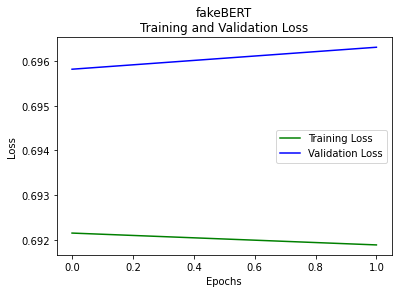

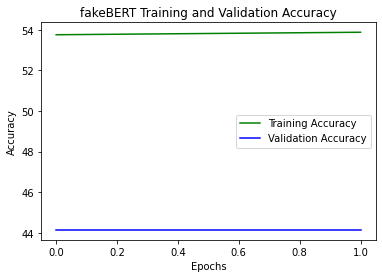

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.689363032579422,58.68055555555556)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,▁█
avg_train_loss,0.69189
epoch,1
train_acc,53.87311
val_accuracy,44.14062
val_loss,0.69631


wandb: Agent Starting Run: 491ezs8o with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.01
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.691504   |   54.27   |  0.693729  |   50.22   |   5.60   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.690736   |   54.11   |  0.694160  |   50.22   |   3.32   


Training complete! Best accuracy: 50.22%.
epochs: [0. 1.] 
train_loss: [0.69150409 0.69073578] 
val_loss: [0.69372854 0.69415954]


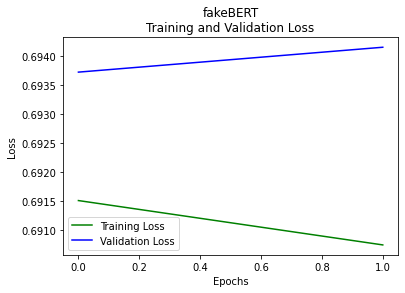

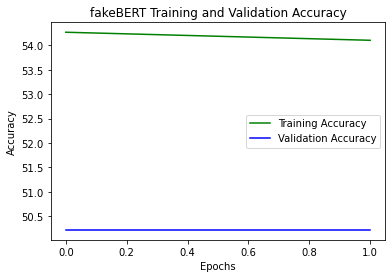

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.6855964064598083,57.99999999999999)


avg_train_loss,█▁
epoch,▁█
train_acc,█▁
val_accuracy,▁▁
val_loss,▁█
avg_train_loss,0.69074
epoch,1
train_acc,54.1059
val_accuracy,50.21701
val_loss,0.69416


wandb: Agent Starting Run: 159qbqwb with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.1
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    | 114896.968741 |   53.23   | 7553.499756 |   50.17   |   6.12   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    | 11348.641124 |   49.15   |  5.006582  |   50.22   |   5.97   


Training complete! Best accuracy: 50.22%.
epochs: [0. 1.] 
train_loss: [114896.96874079  11348.64112425] 
val_loss: [7.55349976e+03 5.00658250e+00]


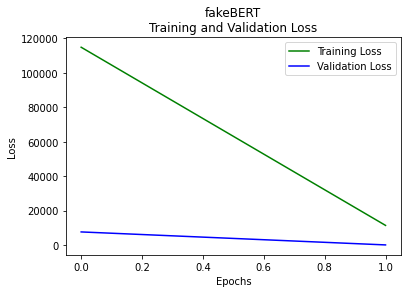

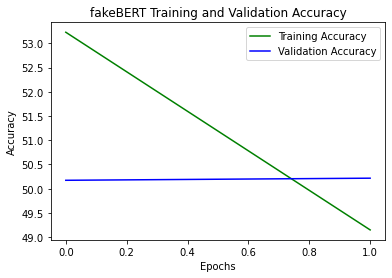

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (4.223867893218994,57.99999999999999)


avg_train_loss,█▁
epoch,▁█
train_acc,█▁
val_accuracy,▁█
val_loss,█▁
avg_train_loss,11348.64112
epoch,1
train_acc,49.14931
val_accuracy,50.21701
val_loss,5.00658


wandb: Agent Starting Run: uwh3s1qe with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.1
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    | 114898.452505 |   53.23   | 7746.189453 |   49.78   |   5.04   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    | 1724.462233  |   50.20   | 50.830025  |   49.09   |   3.36   


Training complete! Best accuracy: 49.78%.
epochs: [0. 1.] 
train_loss: [114898.45250544   1724.46223325] 
val_loss: [7746.18945312   50.83002472]


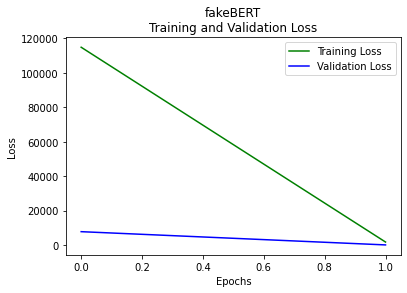

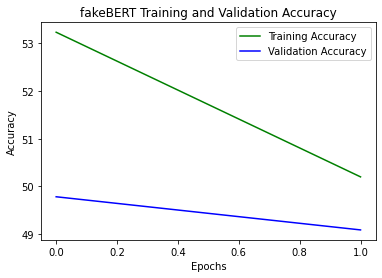

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (17.91400146484375,43.0)


avg_train_loss,█▁
epoch,▁█
train_acc,█▁
val_accuracy,█▁
val_loss,█▁
avg_train_loss,1724.46223
epoch,1
train_acc,50.19965
val_accuracy,49.08854
val_loss,50.83002


wandb: Agent Starting Run: om0v5863 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.691978   |   54.55   |  0.693324  |   50.22   |   5.10   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.692045   |   53.98   |  0.693345  |   50.22   |   3.35   


Training complete! Best accuracy: 50.22%.
epochs: [0. 1.] 
train_loss: [0.6919777  0.69204516] 
val_loss: [0.69332397 0.69334498]


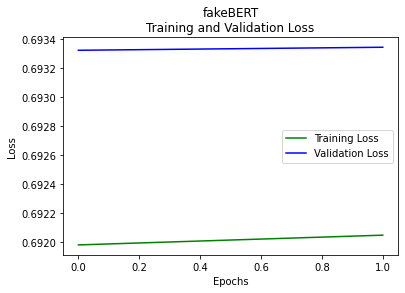

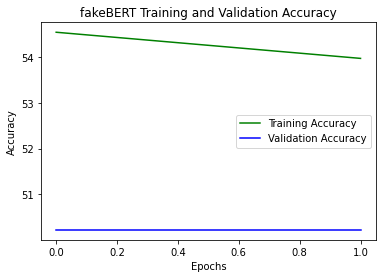

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.6898249983787537,57.99999999999999)


avg_train_loss,▁█
epoch,▁█
train_acc,█▁
val_accuracy,▁▁
val_loss,▁█
avg_train_loss,0.69205
epoch,1
train_acc,53.97569
val_accuracy,50.21701
val_loss,0.69334


wandb: Agent Starting Run: osfz59be with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.01
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   9.948623   |   49.63   |  0.696576  |   44.14   |   5.19   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.693115   |   53.87   |  0.691582  |   55.86   |   5.16   


Training complete! Best accuracy: 55.86%.
epochs: [0. 1.] 
train_loss: [9.94862284 0.69311451] 
val_loss: [0.69657594 0.69158189]


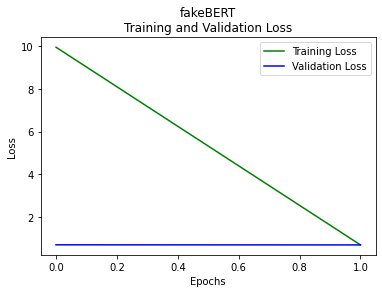

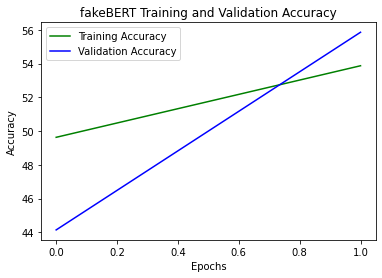

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.695716917514801,41.31944444444444)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,█▁
avg_train_loss,0.69311
epoch,1
train_acc,53.87311
val_accuracy,55.85938
val_loss,0.69158


wandb: Agent Starting Run: jqsfkn1d with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.1
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.694276   |   51.49   |  0.707734  |   44.14   |   5.20   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.688960   |   53.87   |  0.699554  |   44.14   |   3.59   


Training complete! Best accuracy: 44.14%.
epochs: [0. 1.] 
train_loss: [0.69427551 0.68896045] 
val_loss: [0.70773353 0.6995541 ]


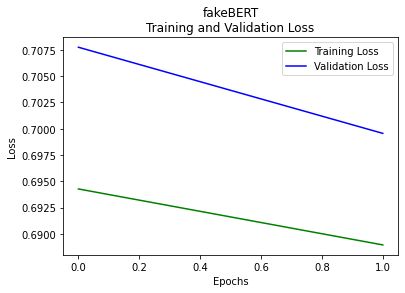

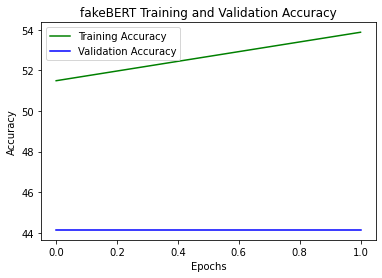

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.6816998720169067,58.68055555555556)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,█▁
avg_train_loss,0.68896
epoch,1
train_acc,53.87311
val_accuracy,44.14062
val_loss,0.69955


wandb: Agent Starting Run: b7t8l3bd with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.001
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.722397   |   49.32   |  0.702562  |   50.22   |   5.70   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.696139   |   56.46   |  0.686473  |   56.64   |   5.97   


Training complete! Best accuracy: 56.64%.
epochs: [0. 1.] 
train_loss: [0.72239718 0.69613925] 
val_loss: [0.70256233 0.68647262]


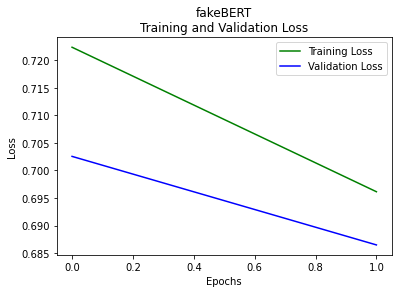

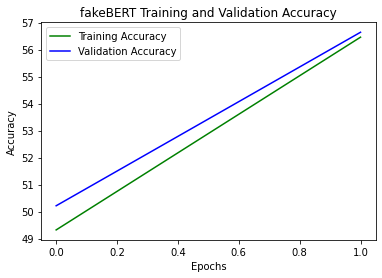

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.6838237047195435,64.0)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,█▁
avg_train_loss,0.69614
epoch,1
train_acc,56.45833
val_accuracy,56.64062
val_loss,0.68647


wandb: Agent Starting Run: digi515n with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.1
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: ada
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.694276   |   51.49   |  0.707732  |   44.14   |   6.15   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.688965   |   53.87   |  0.699532  |   44.14   |   3.49   


Training complete! Best accuracy: 44.14%.
epochs: [0. 1.] 
train_loss: [0.69427563 0.68896543] 
val_loss: [0.70773244 0.69953233]


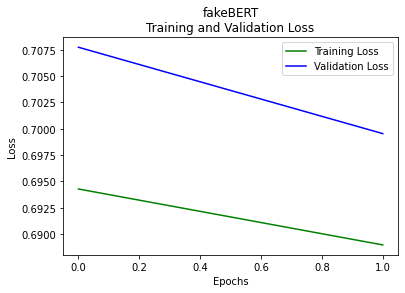

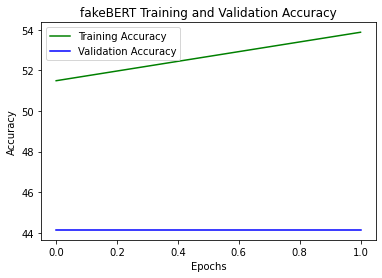

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.6817662417888641,58.68055555555556)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,█▁
avg_train_loss,0.68897
epoch,1
train_acc,53.87311
val_accuracy,44.14062
val_loss,0.69953


wandb: Agent Starting Run: 0qsmuxm8 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	filter_sizes: [3, 4, 5]
wandb: 	learning_rate: 0.01
wandb: 	max_length: 100
wandb: 	num_classes: 2
wandb: 	num_filters: [128, 128, 128]
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: 	test_subset: True
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0d87aa9a260fbf14.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1263b4485102e236.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4576d493e408b00a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   9.949298   |   49.63   |  0.696027  |   44.14   |   5.29   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.693189   |   53.87   |  0.692189  |   55.86   |   6.16   


Training complete! Best accuracy: 55.86%.
epochs: [0. 1.] 
train_loss: [9.94929768 0.69318935] 
val_loss: [0.69602652 0.69218922]


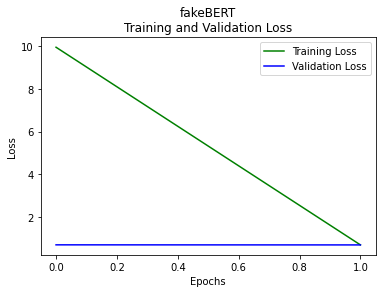

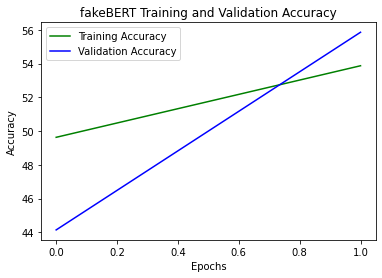

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.6946558356285095,41.31944444444444)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,█▁
avg_train_loss,0.69319
epoch,1
train_acc,53.87311
val_accuracy,55.85938
val_loss,0.69219


In [39]:
from source import train
from source.models.FakeBERT import initialize_model, FakeBERTCNN
from source.dataloader.get_data import bert_data
from source.plot import experiment_plot
from source import train, evaluate
import wandb
import pprint

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-1, 1e-2, 1e-3]
        },
        'batch_size': {
            #'values': [128] # paper value
            'values':[64, 128, 256]
        },
        'epochs':{
            'values':[2]#10]
        },
        'max_length':{
            'values':[100] # paper value
        },
        'dropout':{
            'values':[0.0]#,0.2,0.5]
        },
        'opt':{
            #'values':['ada'] # paper value
            'values':['adam','ada']
        },
        'rho':{ #adagrid opt param
            'values':[0.95]
        },
        'emb_size':{ # should not change
            'value':768
        },
        'num_filters':{
            'value':[128, 128, 128] # [128, 128, 128] in paper
        },
        'filter_sizes':{
            'value':[3, 4, 5] # in paper
        },
        'num_classes':{ # should not change (with standard dataset)
            'value':2
        },
        'test_subset':{
            'value': True
        }
    }
}

def run():
  with wandb.init(project="Fakebert", entity="cs7643-teamscam") as run:
    config = wandb.config
    # Parameters
    MAX_LENGTH = config['max_length']
    EPOCHS = config['epochs']
    BATCH_SIZE = config['batch_size'] # 128 in paper
    NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, config['emb_size']) # The num_tokens comes from max_length in tokens
    NUM_FILTERS = config['num_filters'] # [128, 128, 128] in paper
    FILTER_SIZES = config['filter_sizes'] #[3,4,5] in paper
    NUM_CLASSES = config['num_classes']
    DROPOUT = config['dropout']
    LR = config['learning_rate']
    RHO = config['rho']
    TEST_SUBSET = config['test_subset'] # Whether or not to get a reduced size dataset (700,200,100) in train, validation, test
    EMB_LAYER = 0 # For this model, we are grabbing the embeddings not the bert output

    # Define the dataset 
    data = bert_data(\
                              data_folder = 'data',\
                              train_file = 'Train_Clean.csv',\
                              test_file = 'Test_Clean.csv',\
                              val_file = 'Validate_Clean.csv',\
                              tokenizer_type = 'bert-base-uncased',\
                              data_tokens = None)
    # FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
    data_tokenized = data.tokenize(\
                                        col_tokenize = 'text',\
                                        add_special_tokens = True,\
                                        max_length = MAX_LENGTH,\
                                        truncation = True,\
                                        padding = 'max_length')

    # Get Train, Val data
    train_dataloader, val_dataloader, test_dataloader = data.get_data_loader(batch_size = BATCH_SIZE, test_subset = TEST_SUBSET)

    # Specify loss function
    loss_fn = nn.CrossEntropyLoss()

    set_seed(42)
    cnn_bert = initialize_model(device, \
                                max_len=MAX_LENGTH, \
                                filter_sizes=FILTER_SIZES, \
                                num_filters=NUM_FILTERS, \
                                num_classes=NUM_CLASSES,
                                learning_rate=LR, dropout=DROPOUT)

    # Specify the optimizer
    if (config['opt'] == 'adam'): 
      opt = Adam(cnn_bert.parameters(), lr=LR)
    else:
      opt = Adadelta(cnn_bert.parameters(), lr=LR, rho=RHO)


    results = train.train(emb_model = bert_model, \
                 model = cnn_bert,\
                 loss_fn = loss_fn,\
                 optimizer = opt,\
                 train_dataloader = train_dataloader,\
                 val_dataloader = val_dataloader,\
                 epochs=EPOCHS,\
                 bert_layer = EMB_LAYER)
     
    plot_runner = experiment_plot(results = results,\
                                  save_name = "LINEAR" + '-' \
                                            + 'SEQ' + str(MAX_LENGTH)\
                                            + '-LR' + str(LR)\
                                            + '-DO' + str(DROPOUT)\
                                            + '-BS' + str(BATCH_SIZE),
                                  save_path = "experiments/figures/",\
                                  append_time = True
                                  )
    plot_runner.plot(title_prepend = "fakeBERT",\
                    include_points = False)

    val_loss, val_accuracy = evaluate.evaluate(bert_model, cnn_bert, loss_fn, test_dataloader, EMB_LAYER, epoch_i = 'Test')
    print('Final Loss and Accuracy on Test: (%s,%s)' % (val_loss, val_accuracy))

count = 10   # number of runs to execute
sweep_id = wandb.sweep(sweep_config, project="Fakebert", entity="cs7643-teamscam")
wandb.agent(sweep_id, function=run, count=count)

In [40]:
myrun.finish()

### References

https://romanorac.github.io/machine/learning/2019/12/02/identifying-hate-speech-with-bert-and-cnn.html